In [139]:
import pandas as pd
import seaborn as sns
import warnings # Suppress all warnings 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import spearmanr
from scipy.stats import f_oneway
import scipy.stats as stats
from scipy.stats import levene
from scipy.stats import kruskal
import os
warnings.filterwarnings("ignore")

In [140]:
data = '../data/clean/fema_df_coords.csv'

In [141]:
fema_df = pd.read_csv(data)
fema_df.drop(columns = 'Unnamed: 0', inplace = True)
fema_df = fema_df.dropna()

In [142]:
fema_df = fema_df[fema_df['state'] != 'AK']

In [203]:
figures_folder = "figures"
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

# Function to save figures
def save_figure(name):
    file_path = os.path.join(figures_folder, f"{name}.png")
    plt.savefig(file_path, bbox_inches='tight', dpi=300)
    print(f"Figure saved as {file_path}")

# KPI 1: Incident Frequency vs Distance from EOC

Objective: Test whether incident frequency is related to distance from the nearest EOC.

Hypotheses: 

- Null Hypothesis (H0): There is no significant relationship between incident frequency and average distance from EOCs for different disaster areas.
- Alternative Hypothesis (H1): There is a significant relationship between incident frequency and average distance from EOCs for different disaster areas.

In [147]:
#Group the data by disaster_area to calculate incident frequency and average distance 
incident_freq_area = fema_df.groupby('disaster_area').size().reset_index(name='incident_frequency')
avg_distance_area = fema_df.groupby('disaster_area')['Distance (km)'].mean().reset_index()
freq_distance_df_area = pd.merge(incident_freq_area, avg_distance_area, on='disaster_area')
freq_distance_df_area

,disaster_area,incident_frequency,Distance (km)
0,"Abbeville County, SC",18,164.367000
1,Absentee Shawnee-Citizens Band of Potawatomi T...,3,105.513000
2,"Acadia Parish, LA",34,127.950000
3,"Accomack County, VA",11,284.467000
4,"Ada County, ID",5,11.014000
...,...,...,...
3799,"Zavala County, TX",13,152.468923
3800,"Zia Pueblo Indian Reservation, NM",2,113.524000
3801,"Ziebach County, SD",15,198.489000
3802,"Zuni Pueblo Indian Reservation, AZ",2,229.730000


Figure saved as figures/Incident_Frequency_Average_Distance_to_EOC_by_Disaster_Area.png


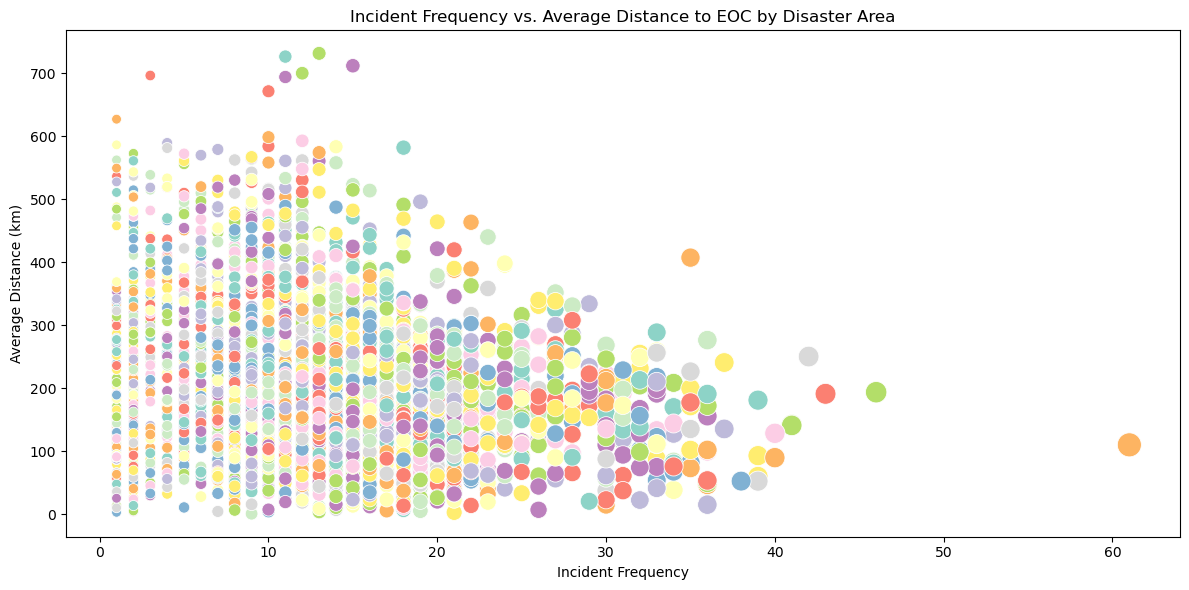

In [148]:
#Visualize relationship

plt.figure(figsize=(12, 6))
sns.scatterplot(data=freq_distance_df_area, x='incident_frequency', y='Distance (km)', hue='disaster_area', palette='Set3', size='incident_frequency', sizes=(50, 300), legend=None)

# Improve readability
plt.title("Incident Frequency vs. Average Distance to EOC by Disaster Area")
plt.xlabel("Incident Frequency")
plt.ylabel("Average Distance (km)")

# Display the plot
plt.tight_layout()
save_figure("Incident_Frequency_Average_Distance_to_EOC_by_Disaster_Area")
plt.show()

In [149]:
# Test for normality
shapiro_freq = shapiro(freq_distance_df_area['incident_frequency'])
shapiro_dist = shapiro(freq_distance_df_area['Distance (km)'])

print(f"Incident Frequency Normality: {shapiro_freq}")
print(f"Distance Normality: {shapiro_dist}")

Incident Frequency Normality: ShapiroResult(statistic=0.949843523976845, pvalue=3.2319402226759007e-34)
Distance Normality: ShapiroResult(statistic=0.9373858470447087, pvalue=2.370607882807274e-37)


These results indicate the distribution of the two variables is not normal.

In [151]:
#Given the distribution of our data is not normal, we aim to see  whether there is a monotonic relationship between two variables

# Calculate Spearman's rank correlation
spearman_corr, p_value = spearmanr(freq_distance_df_area['incident_frequency'], freq_distance_df_area['Distance (km)'])

# Display the results
print(f"Spearman's Rank Correlation: {spearman_corr}, p-value: {p_value}")

Spearman's Rank Correlation: -0.0461607474322933, p-value: 0.004404761330007933


Spearman’s Rank Correlation coefficient of -0.046 suggests a very weak negative relationship between incident frequency and distance from the EOC.  The relationship is weak and not significant in a practical sense.
p-value: The p-value of 0.004 is less than 0.05, which indicates that the result is statistically significant. However, due to the very small magnitude of the correlation (-0.046), the relationship is weak and likely not meaningful for practical purposes.

Conclusion: the weak negative correlation between incident frequency and distance from the EOC could indicate that EOC location selection may not currently prioritize proximity to disaster areas with higher incident frequencies. This could be an opportunity for improvement in the decision-making process for EOC placement.

# KPI 2: Incident Type vs. Travel Time

Different types of incidents may require different response times. If certain incident types consistently result in longer travel times, this could indicate that the EOCs are not equipped to handle those incidents effectively or that additional resources are needed closer to those areas.

Objective: Test whether travel time varies significantly by incident type.

Hypotheses:

Null Hypothesis (H0): Travel time does not vary by incident type.

Alternative Hypothesis (H1): Travel time varies significantly by incident type, suggesting logistical inefficiencies.

In [157]:
#Group the data
travel_time_data = fema_df[['incidentType', 'Duration (minutes)']]

Figure saved as figures/hist_time_state_inctype.png


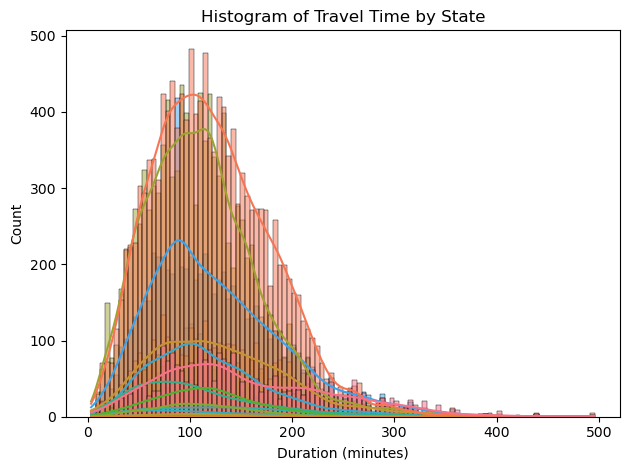

In [158]:
#Check for normality
plot = sns.histplot(data=travel_time_data, x='Duration (minutes)', kde=True, hue='incidentType')
plt.title('Histogram of Travel Time by State')
plt.legend([], [], frameon=False) 
plt.tight_layout()
save_figure("hist_time_state_inctype")
plt.show()

Figure saved as figures/Q-Q_Plot_of_Travel_Times.png


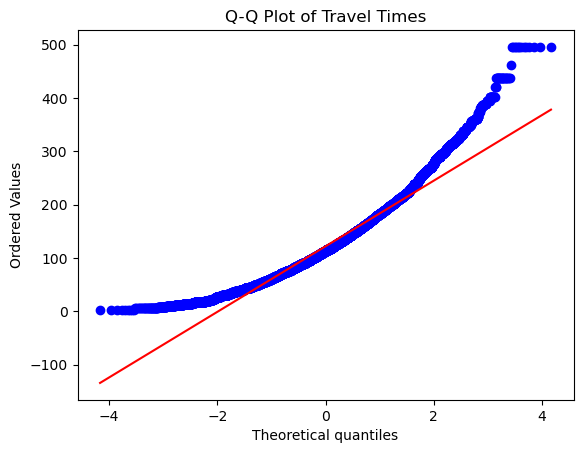

In [159]:
stats.probplot(travel_time_data['Duration (minutes)'], dist="norm", plot=plt)
plt.title("Q-Q Plot of Travel Times")
save_figure("Q-Q_Plot_of_Travel_Times")
plt.show()

In [160]:
# KPI 2: Variance equality test for incident types
levene_test_incident = levene(
    *[travel_time_data[travel_time_data['incidentType'] == group]['Duration (minutes)'] 
      for group in travel_time_data['incidentType'].unique()]
)
print("Levene's Test for Incident Types:", levene_test_incident)


Levene's Test for Incident Types: LeveneResult(statistic=58.252065039719724, pvalue=2.9995086576394496e-231)


Figure saved as figures/violin_time_inctype.png


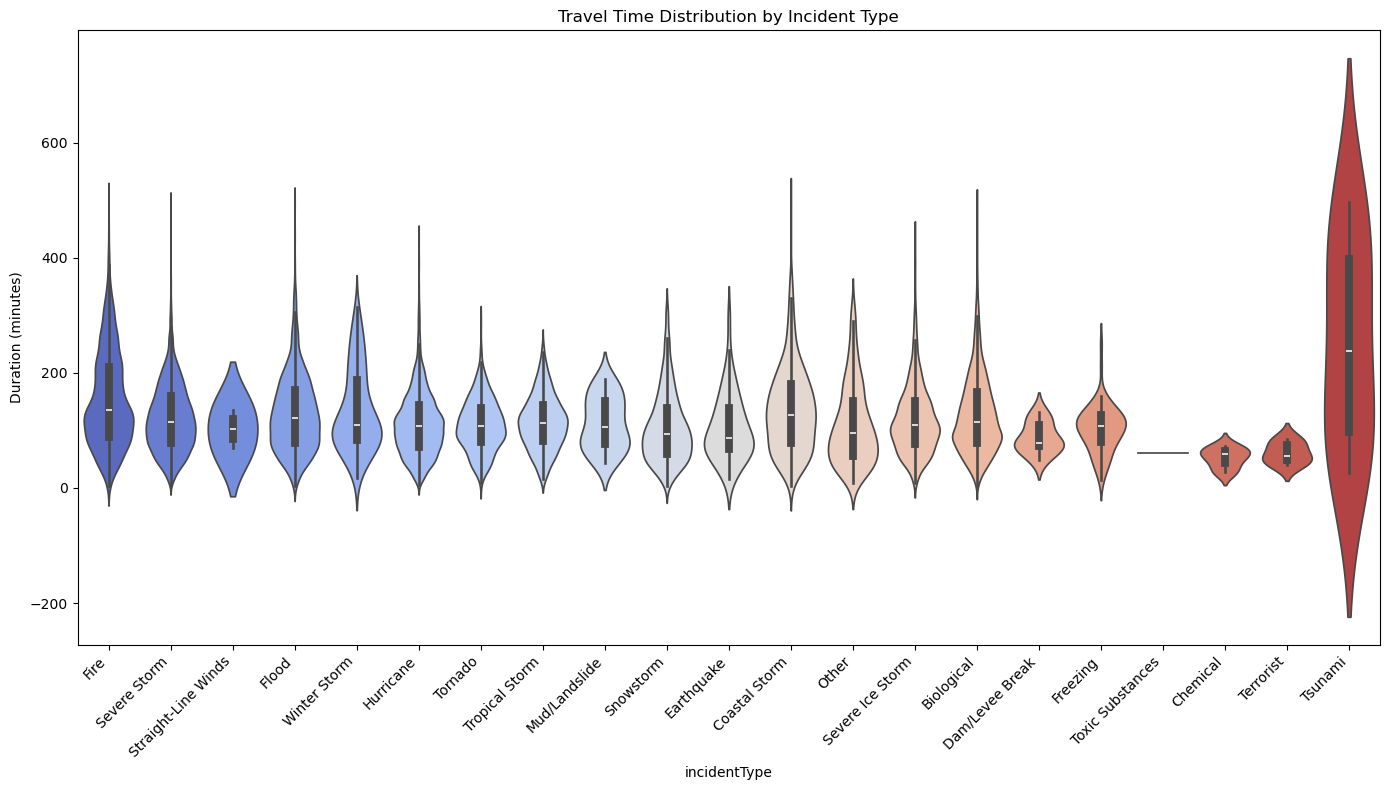

In [161]:
#Visualize the relationship

plt.figure(figsize=(14, 8))

# Create a violin plot
sns.violinplot(data=travel_time_data, x='incidentType', y='Duration (minutes)', palette='coolwarm')
plt.xticks(rotation=45, ha="right")
plt.title('Travel Time Distribution by Incident Type')

# Adjust the layout to make sure labels fit within the plot
plt.tight_layout()
save_figure("violin_time_inctype")
plt.show()


In [162]:
kruskal_test_incident = kruskal(
    *[travel_time_data[travel_time_data['incidentType'] == group]['Duration (minutes)'] 
      for group in travel_time_data['incidentType'].unique()]
)
print("Kruskal-Wallis Test for Incident Types:", kruskal_test_incident)

Kruskal-Wallis Test for Incident Types: KruskalResult(statistic=935.1885841202081, pvalue=2.534317479369266e-185)


Statistic: The test statistic (935.19) represents the difference between the groups. A higher value suggests a larger difference between the groups.
P-value: The p-value is extremely small, indicating a very strong rejection of the null hypothesis (that all groups have the same distribution).

Conclussion: There is strong evidence that incident type does have an effect on response time, and that the different types of incidents are associated with different distributions of response times. If some incident types consistently require longer travel times, it may suggest that EOCs are not ideally positioned to handle these types of incidents, particularly in certain regions. This would be a key factor when assessing the overall "optimality" of EOC locations.

# KPI 3: State-level Travel Time Disparities

Analyzing travel time disparities across states provides a regional perspective, helping to identify underserved areas where response times are unreasonably long. This could highlight specific regions that would benefit from additional EOCs or better routing strategies.


Objective: Test whether travel times vary significantly across states.

Hypotheses:

Null Hypothesis (H0): Travel times do not vary significantly across states.

Alternative Hypothesis (H1): Travel times vary significantly across states, indicating regional disparities in EOC coverage.

In [169]:
#Group data
state_travel_data = fema_df[['state', 'Duration (minutes)']]

Figure saved as figures/hist_time_state.png


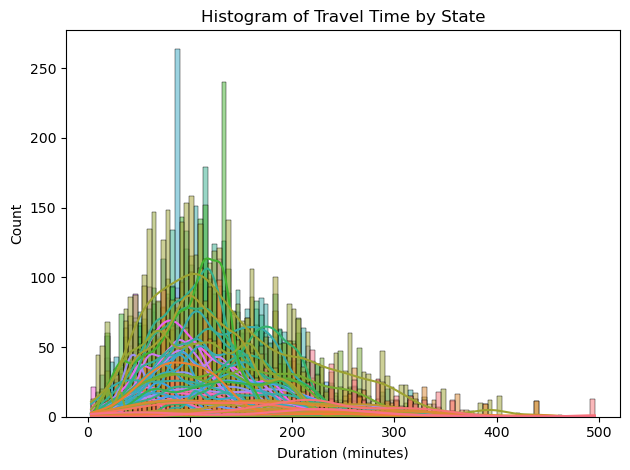

In [170]:
#Check for normality
plot = sns.histplot(data=state_travel_data, x='Duration (minutes)', kde=True, hue='state')
plt.title('Histogram of Travel Time by State')
plt.legend([], [], frameon=False) 
plt.tight_layout()
save_figure("hist_time_state")  # Save this plot
plt.show()

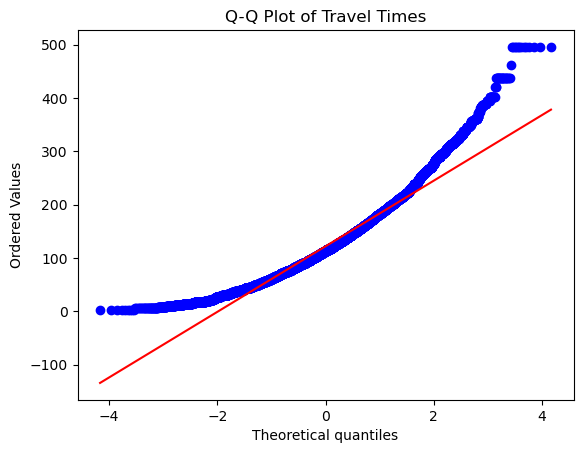

In [171]:
stats.probplot(state_travel_data['Duration (minutes)'], dist="norm", plot=plt)
plt.title("Q-Q Plot of Travel Times")
plt.show()

Figure saved as figures/avg_time_st.png


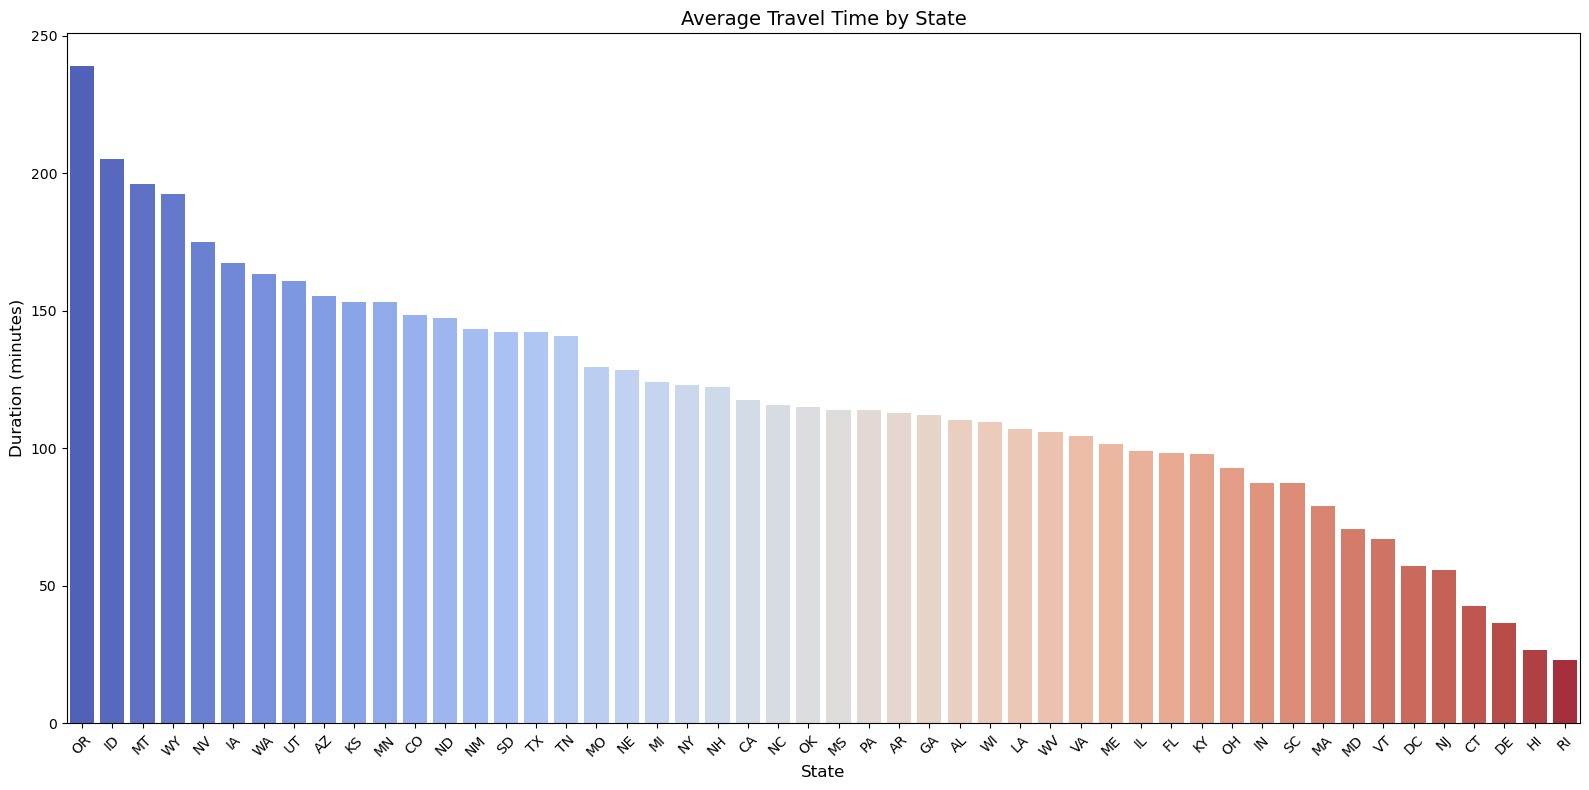

In [172]:
#Visualize relationship
# Calculate average travel time
avg_travel_time = state_travel_data.groupby('state')['Duration (minutes)'].mean().reset_index()

# Sort by travel time
avg_travel_time = avg_travel_time.sort_values(by='Duration (minutes)', ascending=False)

# Set the figure size
plt.figure(figsize=(16, 8))  # Adjust dimensions as needed

# Create the bar plot
sns.barplot(data=avg_travel_time, x='state', y='Duration (minutes)', palette='coolwarm')
plt.xticks(rotation=45, fontsize=10)  # Rotate for readability and adjust font size
plt.title('Average Travel Time by State', fontsize=14)
plt.ylabel('Duration (minutes)', fontsize=12)
plt.xlabel('State', fontsize=12)
plt.tight_layout()  # Ensure no clipping of labels
save_figure("avg_time_st")  # Save this plot

plt.show()

In [173]:
levene_test_state = levene(
    *[state_travel_data[state_travel_data['state'] == group]['Duration (minutes)'] 
      for group in state_travel_data['state'].unique()]
)
print("Levene's Test for States:", levene_test_state)

Levene's Test for States: LeveneResult(statistic=154.3816667912024, pvalue=0.0)


In [174]:
kruskal_test_state = kruskal(
    *[state_travel_data[state_travel_data['state'] == group]['Duration (minutes)'] 
      for group in state_travel_data['state'].unique()]
)
print("Kruskal-Wallis Test for States:", kruskal_test_state)

Kruskal-Wallis Test for States: KruskalResult(statistic=8184.241996316405, pvalue=0.0)


Statistic: The test statistic (8184.24) is very high, suggesting a substantial difference in response times between the states.
The p-value is 0.0, which means that the null hypothesis (which assumes that response times are the same across states) can be rejected with high confidence. This indicates that there is a statistically significant difference in response times across the states.

Conclussion: This result suggests that response time varies significantly by state, meaning that certain states may have longer or shorter response times compared to others.

In [177]:
tableau_df = fema_df.to_csv('../data/clean/fema_df_tableau.csv')

In [178]:
figures_folder = "figures"
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

figure_names = {
    "Incident_Frequency_Average_Distance_to_EOC_by_Disaster_Area": 1,  # Replace with your actual figure numbers
    "hist_time_state_inctype": 2,
    "Q-Q_Plot_of_Travel_Times": 3,
    "violin_time_inctype": 4,
    "hist_time_state": 5, 
    "avg_time_st": 6
}

# Save all figures with their assigned names
for name, figure_number in figure_names.items():
    plt.figure(figure_number)
    figure_path = os.path.join(figures_folder, f"{name}.png")
    plt.savefig(figure_path, dpi=300, bbox_inches='tight')
    print(f"Figure '{name}' saved as {figure_path}")

print("All named figures have been saved.")

Figure 'Incident_Frequency_Average_Distance_to_EOC_by_Disaster_Area' saved as figures/Incident_Frequency_Average_Distance_to_EOC_by_Disaster_Area.png
Figure 'hist_time_state_inctype' saved as figures/hist_time_state_inctype.png
Figure 'Q-Q_Plot_of_Travel_Times' saved as figures/Q-Q_Plot_of_Travel_Times.png
Figure 'violin_time_inctype' saved as figures/violin_time_inctype.png
Figure 'hist_time_state' saved as figures/hist_time_state.png
Figure 'avg_time_st' saved as figures/avg_time_st.png
All named figures have been saved.


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>